# Country Peer Groups
The responses to the Corona-Virus outbreak have differed significantly between countries. As only the result of the taken measures are known it is difficult to say how individual measures have contributed to these results. Therefore, this notebook attempts to form peer groups of countries which are most similar with regards to their state of development, demography, health care infrastructure and population spread. These four dimensions are chosen for the following reasons:
* __State of Development__: The UN's human development index simply serves as a data point to take into account a country's general nature to ensure that the countries compared are somewhat similar besides the corona-specific points.
* __Demography__: There is strong evidence suggesting that the case fatality of Covid-19 varies significantly with a person's age. (Source: [Our World in Data](https://ourworldindata.org/mortality-risk-covid#current-data-across-countries-suggests-that-the-elderly-are-most-at-risk))
* __Health Care__: Data suggests that an overwhelmed health care system heavily impacts the case fatality rate. As seen in China the heavily affected region of Hubei reported a fatality rate of ~4%. The rest of China fared a lot better with a rate of ~1%. (Source: [Tomas Pueyo](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)).
* __Population Spread__: This is included as the virus is passed on from one person to another. The closer people live together the more likely is their infection.


## Set Up
This notebook makes heavy use of the [pycountry library](https://pypi.org/project/pycountry/). This is especially useful because country names are inconsistent between different data sources and the library provides a fuzzy search function. Countries can then be mapped to their [ISO-3166-1](https://en.wikipedia.org/wiki/ISO_3166-1_numeric) numeric codes which is subsequently used as the primary key.

In [127]:
PATH = 'https://raw.githubusercontent.com/henrythier/covid-19/master'
SAVE_FILES = False
import pycountry
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import numpy as np
import io
import requests
import string

In [44]:
#Avoid disambiguities due to different country namings
#clean raw countrynames
def clean_names(df, col):
    df[col] = df[col].apply(lambda x: x.split(" [")[0])
    df[col] = df[col].apply(lambda x: x.split(" (")[0])
    df[col] = df[col].apply(lambda x: x.split("[")[0])
    df[col] = df[col].apply(lambda x: x.split("(")[0])
    df[col] = df[col].apply(lambda x: x.split(",")[0])

#country search
def get_iso_from_name(countryname):
    try:
        return(pycountry.countries.search_fuzzy(countryname)[0].numeric)
    except LookupError:
        return 'Not Found'
   
def get_name_from_iso(iso):
    try:
        return(pycountry.countries.get(numeric=iso).name)
    except AttributeError:
        print('Could not find ISO %s' % countryname)
        
def name_col_to_iso(df, col):
    df['iso'] = df[col].apply(lambda x: get_iso_from_name(x))

# Function to standardise all tables so that ISO code is index
def standardise_table(df, col = 'Country'):
    clean_names(df, col)
    name_col_to_iso(df, col)
    df = df.set_index('iso')
    df = df.drop(columns=[col])
    return df

# Make a dictionary to quickly switch between ISO and country name
country_dict = {}
country_list = list(map(lambda x: {x.numeric: x.name}, list(pycountry.countries)))
for c in country_list:
    country_dict.update(c)
country_list = list(country_dict.values())

## Peer Group

### Development Index
Only countries with a similar state of development are compared. Therefore, the [UN's Human Development](http://hdr.undp.org/en/data#) is used.

In [45]:
#read data
hdi_data = pd.read_csv(PATH + '/data/raw/hdi.csv', header=1)

#remove columns that are not needed and summary rows
last_year = hdi_data.columns[-2]
hdi_rank = 'HDI Rank (' + last_year + ')'
hdi_data = hdi_data[['Country', hdi_rank, last_year]]
hdi_data = hdi_data[hdi_data[hdi_rank] != ' '].dropna()
hdi_data[[hdi_rank, last_year]] = hdi_data[[hdi_rank, last_year]].apply(pd.to_numeric)
hdi_data = hdi_data.set_index(hdi_rank)
hdi_data.sort_values(by=[last_year], inplace=True)
hdi_data = standardise_table(hdi_data, 'Country')

if SAVE_FILES:
    hdi_data.to_csv(PATH + '/data/clean/hdi.csv')

### Demographics

[Populationpyramid](https://www.populationpyramid.net/) provides demographic data on 130 countries broken down into age brackets of 5 years compiled from a range of [sources](https://www.populationpyramid.net/sources). These are retrieved and used to calculate the expected fatality if a random person was infected.

In [46]:
try:
    demographics = pd.read_csv(PATH + '/data/raw/demographics.csv', index_col=[0], dtype={'iso':'string'})
except FileNotFoundError:
    demographics = pd.DataFrame()
    for country in list(pycountry.countries):
        country_code = country.numeric
        try:
            url="https://www.populationpyramid.net/api/pp/" + country_code +"/2019/?csv=true"
            s=requests.get(url).content
            c=pd.read_csv(io.StringIO(s.decode('utf-8')))
            c[country_code] = (c['M'] + c['F']) / (c['M'].sum() + c['F'].sum()) * 100
            c = c[['Age', country_code]].set_index('Age').T.reset_index().rename(columns={"index": "iso"})
            demographics = pd.concat([demographics,c], ignore_index=True)
        except KeyError:
            print('%s not found' % country.name)
    demographics = demographics.dropna()
    if SAVE_FILES:
        demographics.to_csv(PATH + '/data/raw/demographics.csv', index=False)
    
demographics

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
iso,,,,,,,,,,,,,,,,,,,,,
533,5.575257,5.525402,6.523436,6.847021,7.159319,6.652306,4.956307,5.625112,6.498039,7.205411,...,8.488463,7.002229,5.455794,3.830344,2.390202,1.489996,0.651873,0.195656,0.040448,0.003763
004,14.822612,14.199954,13.449686,11.879509,9.974920,7.845032,6.292801,5.224774,4.187333,3.295234,...,2.046441,1.549705,1.133607,0.788052,0.417851,0.192972,0.065021,0.015696,0.002455,0.000097
024,17.817495,15.633402,13.171144,10.658948,8.752732,7.390912,6.196567,5.012852,4.038492,3.241717,...,2.066453,1.424926,0.915039,0.650662,0.364920,0.188476,0.063167,0.014891,0.002086,0.000116
008,5.868036,5.722734,5.809027,7.218337,8.175221,8.550241,7.498213,5.600065,5.401690,6.067556,...,7.048772,6.275233,4.762726,3.661478,2.932716,1.792904,0.783814,0.233155,0.033913,0.001666
784,5.130021,5.170571,4.426230,4.120259,7.646989,14.364754,17.637075,13.804548,9.708290,7.236806,...,3.324059,1.642041,0.500127,0.355518,0.180635,0.066956,0.041011,0.009109,0.003091,0.000307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,13.952297,12.501712,11.410857,9.547270,8.357476,7.203706,5.755658,5.326420,5.070195,4.916461,...,3.682526,2.861593,1.969121,1.313593,0.921392,0.462726,0.180625,0.077121,0.008118,0.000000
887,14.055010,13.231422,11.936960,10.793085,9.983529,9.437739,7.653120,5.904024,4.417922,3.260694,...,2.169085,1.682780,1.227272,0.854350,0.474327,0.232906,0.085282,0.023332,0.004396,0.000261
710,9.880093,9.897841,9.190441,8.297448,8.470609,9.002176,9.093713,7.885044,6.298388,5.392099,...,3.702169,2.990053,2.249906,1.473503,0.969861,0.499058,0.181259,0.037375,0.004138,0.000084


[Salje et al.](https://science.sciencemag.org/content/early/2020/05/12/science.abc3517) report Infection Fatality Rates for France in age brackets of ten years. These can be used to calculate the fatality risk if a random person catches the virus.

In [47]:
demographics = pd.read_csv(PATH + '/data/raw/demographics.csv', index_col=[0], dtype={'iso':'string'})

# infection fatality rates in brackets of 10 years
ifr = [0.00001, 0.00001, 0.00007, 0.0002, 0.0006, 0.002, 0.009, 0.024, 0.101, 0.101, 0.101]
# adapt to 5 year brackets
ifr = np.repeat(ifr, 2)

# caclulate probability per country
mortality = pd.DataFrame(index=demographics.index, columns=demographics.columns)
counter = 0
for column in demographics.columns[1:]:
    mortality[column] = demographics[column] * ifr[counter]
    counter += 1
    
mortality = pd.DataFrame(mortality.agg("sum", axis="columns"), columns = ['Mortality'])

if SAVE_FILES:
    mortality.to_csv(PATH + "/data/clean/mortality.csv")
mortality

,Mortality
iso,
533,0.310298
004,0.054471
024,0.049087
008,0.333359
784,0.043258
...,...
882,0.111747
887,0.062072
710,0.115046


### Health Care
The [World Bank](https://data.worldbank.org/indicator/SH.MED.BEDS.ZS) details acute care beds in hospitals per 1,000 inhabitants by country annually. However, not all countries report numbers for every year. To ensure that the number is somewhat representative only countries which report a figure after 2010 are considered.

In [48]:
hospital_data = pd.read_csv(PATH + '/data/raw/hospital_beds.csv', header=2, index_col=0).drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
hospital_data = hospital_data[hospital_data.columns[-12:-1]].T.fillna(method='ffill').T[hospital_data.columns[-2]].dropna()
hospital_data.sort_values()
hospital_data = hospital_data.reset_index()
hospital_data = standardise_table(hospital_data, 'Country Name')
hospital_data = hospital_data.drop(['Not Found'])

if SAVE_FILES:
    hospital_data.to_csv(PATH + '/data/clean/hospitals.csv')

### Urbanisation
The [World Bank](https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS) details the share of inhabitants living in urban areas by country annually. However, not all countries report numbers for every year. To ensure that the number is somewhat representative only countries which report a figure after 2010 are considered.

In [49]:
urban_data = pd.read_csv(PATH + '/data/raw/urbanisation.csv', header=2, index_col=0).drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
urban_data = urban_data[urban_data.columns[-12:-1]].T.fillna(method='ffill').T[urban_data.columns[-2]].dropna()
urban_data.sort_values()
urban_data = urban_data.reset_index()
urban_data = standardise_table(urban_data, 'Country Name')
urban_data = urban_data.drop(['Not Found'])

if SAVE_FILES:
    urban_data.to_csv(PATH + '/data/clean/urbanisation.csv')

### Aggregation 
The data from the different sources is merged into one dataframe.

In [50]:
# read all the clean files
file_names = ['hdi', 'hospitals', 'urbanisation', 'mortality']
variable_names = {'hdi': 'Development',
                 'hospitals': 'Health Care',
                 'urbanisation': 'Population Spread',
                 'mortality': 'Mortality'}
data = {}
for f in file_names:
    data[f] = pd.read_csv(PATH + '/data/clean/' + f + '.csv', dtype={'iso':'string'})\
    .rename(columns={'Country Name': 'Country', '2019': f, '2018': f})
    
#merge tables
all_frames = data[file_names[0]]

for key in data:
    if key == file_names[0]:
        continue
    all_frames = all_frames.merge(data[key], how='outer', on=['iso'])
    
all_frames = all_frames.set_index('iso')
all_frames = all_frames.rename(columns=variable_names)

if SAVE_FILES:
    all_frames.to_csv(PATH + '/data/clean/aggregated.csv')

### Distance calculation
The distance is calculated for each dimension to retrieve a peer group.

In [51]:
aggregated_data = pd.read_csv(PATH + '/data/clean/aggregated.csv', index_col=[0], dtype={'iso':'string'})
aggregated_data

,Development,Health Care,Population Spread,Mortality
iso,,,,
566,0.377,0.3,16.425,0.053747
566,0.377,0.3,50.344,0.053747
566,0.534,0.3,16.425,0.053747
566,0.534,0.3,50.344,0.053747
140,0.381,1.0,41.364,0.059786
...,...,...,...,...
175,NaN,NaN,NaN,0.105648
562,NaN,NaN,NaN,0.050984
638,NaN,NaN,NaN,0.319425


First the data is normalised to give equal weight to each attribute and countries with missing attributes are dropped.

In [52]:
data = aggregated_data.dropna()
data = data.loc[~data.index.duplicated(keep=False)]
data = (data-data.min())/(data.max()-data.min())

if SAVE_FILES:
    data.to_csv(PATH + '/data/clean/normalised.csv')

To calculate the euclidean distance from the reference country - first pick a reference country

In [53]:
country_drops = widgets.Combobox(options=country_list, value="")
country_drops

Combobox(value='', options=('Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra…

In [55]:
comp_country_name = country_drops.value
comp_country = pycountry.countries.get(name=comp_country_name)
comp_country

Country(alpha_2='SE', alpha_3='SWE', name='Sweden', numeric='752', official_name='Kingdom of Sweden')

In [56]:
comp_country.data = data.loc[comp_country.numeric]
dist_string = 'Distance'
data[dist_string] = 0.0
columns = data.columns

for index, row in data.iterrows():
    dist = row[columns[:-1]] - comp_country.data[columns[:-1]]
    dist = dist ** 2
    dist = dist.sum()
    data.at[index, dist_string] = dist
    
peer_group = data.sort_values(dist_string)
peer_group

,Development,Health Care,Population Spread,Mortality,Distance
iso,,,,,
752,0.970332,0.187970,0.855476,0.638256,0.000000
208,0.958115,0.180451,0.860569,0.578594,0.003791
826,0.940663,0.203008,0.809102,0.598431,0.004843
124,0.944154,0.195489,0.786255,0.545372,0.014161
246,0.949389,0.323308,0.831915,0.672328,0.020471
...,...,...,...,...,...
140,0.000000,0.067669,0.325775,0.021202,1.617354
231,0.155323,0.015038,0.088895,0.043012,1.636107
854,0.092496,0.022556,0.187724,0.009404,1.639305


## Display countries peer group with country names

In [57]:
disp = peer_group.reset_index()
disp.replace({'iso': country_dict}).rename(columns={'iso': 'Country'}).set_index('Country').head(20)

,Development,Health Care,Population Spread,Mortality,Distance
Country,,,,,
Sweden,0.970332,0.187970,0.855476,0.638256,0.000000
Denmark,0.958115,0.180451,0.860569,0.578594,0.003791
United Kingdom,0.940663,0.203008,0.809102,0.598431,0.004843
Canada,0.944154,0.195489,0.786255,0.545372,0.014161
Finland,0.949389,0.323308,0.831915,0.672328,0.020471
Spain,0.893543,0.218045,0.773721,0.729453,0.021802
Norway,1.000000,0.285714,0.795879,0.526992,0.026366
New Zealand,0.942408,0.203008,0.845207,0.472076,0.028727
Australia,0.972077,0.278195,0.839159,0.494788,0.028993


## Comparison of the measures
Having found an adequate peergroup for given country, we can now compare the course of the outbreak within the peer group. Therefore, data on virus is retrieved from [Ourworldindata](https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv).

In [115]:
owid_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

As our world uses a 3-letter code as a key these have to be mapped to the previously used 3-digit identifier.

In [118]:
def alpha_3_to_numeric(x):
    country =  pycountry.countries.get(alpha_3=x)
    if country is None:
        return np.nan
    return pycountry.countries.get(alpha_3=x).numeric

covid_df = owid_df.copy()
covid_df['iso'] = covid_df['iso_code'].apply(alpha_3_to_numeric)
covid_df = covid_df[covid_df['iso'].notna()]
covid_df.set_index('iso', inplace=True)

Then we define a function which takes in four parameters:
* comparison_metric: by which metric do we want to compare the countries
* threshold_metric: what metric is used to determine "day 0" in each country
* threshold: what value does the threshold_metric have to surpass. 
* data: dataframe containing all the information
    
To illustrate this, if we wished to compare the countries by the total deaths per million with respect to the day at which the country reported a total of 5 confirmed deaths, the parameters would be as follows:
* comparison_metric: 'total_deaths_per_million'
* threshold_metric: 'total_deaths'
* threshold: 5

In [60]:
def choose_metric(comparison_metric, threshold_metric, threshold, owid_data):
    
    # remove unwanted columns and make dates column headers
    comparison_df = owid_data[['date', comparison_metric]].reset_index()
    comparison_df = comparison_df.pivot_table(index=['iso'], columns='date', values=comparison_metric)
    
    # init df for threshold metric
    threshold_df = owid_data[['date', threshold_metric]].reset_index()
    threshold_df = threshold_df.pivot_table(index=['iso'], columns='date', values=threshold_metric)
    
    # find first day where threshold was met for each country
    countries = threshold_df.index.values
    first_day = pd.DataFrame(columns=countries, index=['day_one'])
    num_of_days = len(threshold_df.columns)
    threshold_df.columns = np.arange(num_of_days)
    threshold_df = threshold_df.T
    
    for country in countries:
        try:
            day_one = threshold_df[country][threshold_df[country]>=threshold].index[0]
        except IndexError:
            day_one = num_of_days

        first_day.at['day_one', country] = day_one

    first_day = first_day.T
    first_day
    
    # set everything to threshold day
    set_to_zero = comparison_df
    for i in comparison_df.index:
        try:
            set_to_zero.loc[i] = comparison_df.loc[i].shift(-first_day['day_one'].loc[i])
        except KeyError:
            continue

    set_to_zero.columns = np.arange(len(comparison_df.columns))
    set_to_zero.dropna(axis='columns', how='all', inplace=True)
    return set_to_zero

Run the function with the desired parameter values.

In [123]:
comparison_metric = 'total_deaths_per_million'
threshold_metric = 'total_deaths'
threshold = 5
metric_frame = choose_metric(comparison_metric, threshold_metric, threshold, covid_df)

Only keep a number of countries to ensure the plot is readable in the end.

In [124]:
peer_group_size = 10

# only keep x closest countries
peergroup_metric = metric_frame.loc[peer_group.head(peer_group_size).index].dropna(axis='columns', how='all')

# exchange numeric for country name
peergroup_metric = peergroup_metric.reset_index().replace({'iso': country_dict}).rename(columns={'iso': 'Country'})
peergroup_metric

,Country,0,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,96
0,Sweden,0.693,0.792,0.990,0.990,1.584,1.980,2.079,2.475,3.565,...,476.668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Denmark,1.036,1.554,2.244,2.244,4.144,5.525,5.870,7.078,8.978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United Kingdom,0.103,0.103,0.133,0.147,0.412,0.633,0.957,1.193,1.694,...,593.068,596.073,597.207,598.017,602.230,605.839,608.063,NaN,NaN,NaN
3,Canada,0.212,0.238,0.265,0.318,0.477,0.530,0.636,0.715,0.927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Finland,1.263,1.624,1.985,2.346,3.068,3.068,3.429,3.610,4.512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Spain,0.107,0.107,0.107,0.599,0.749,1.005,1.797,2.588,2.909,...,580.197,580.219,580.326,580.347,580.368,580.390,580.390,580.39,580.39,580.39
6,Norway,1.107,1.291,1.291,1.291,1.476,1.845,2.214,2.582,2.951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,New Zealand,1.037,1.866,1.866,1.866,2.281,2.281,2.488,2.488,2.696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Australia,0.196,0.196,0.196,0.235,0.235,0.275,0.275,0.275,0.275,...,4.000,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Iceland,17.582,17.582,17.582,17.582,20.513,23.443,23.443,23.443,23.443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the chosen comparison metric as a function of time.

[]

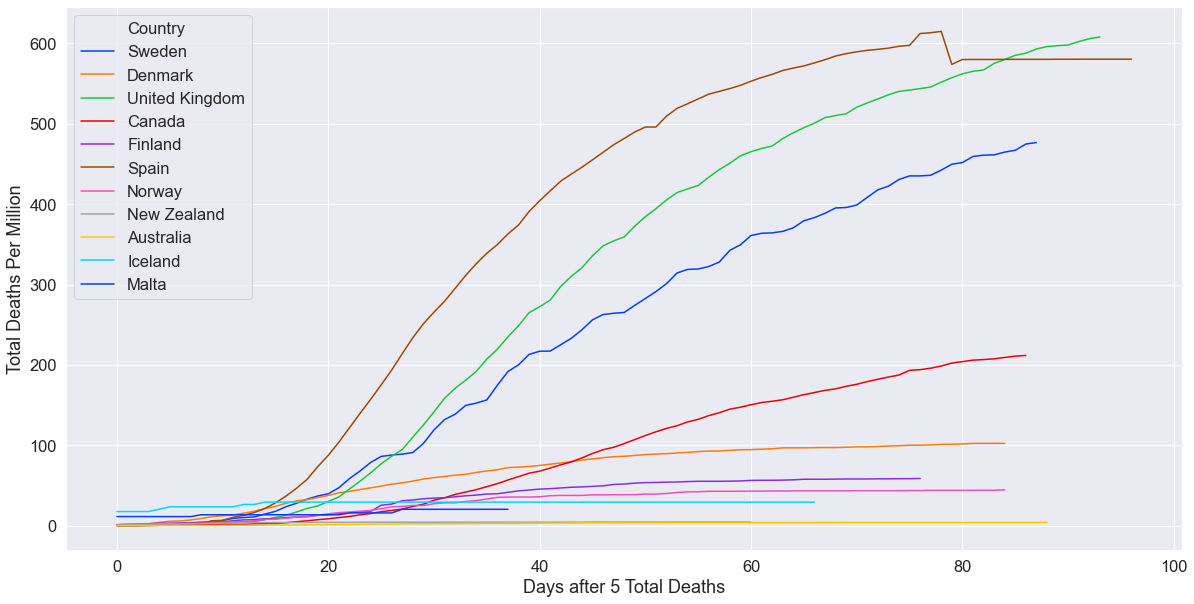

In [129]:
def pretty_name(x):
    x = x.replace('_', ' ')
    x = string.capwords(x)
    return x

threshold_name = 'Days after ' + str(threshold) + ' ' + pretty_name(threshold_metric)
comparison_name = pretty_name(comparison_metric)

# Melt to long format for visualisation
vis = peergroup_metric.melt(id_vars=['Country'], var_name=threshold_name, value_name=comparison_name)

# visualise data in lineplot
plt.rcParams["figure.figsize"] = (20,10)
sns.set()
sns.set(font_scale=1.5)
sns.lineplot(x=threshold_name, y=comparison_name, hue='Country', data=vis, palette=sns.color_palette("bright", 11))
plt.plot()